# Repetition code

In [1]:
import import_ipynb
import TQEC_tools
import numpy as np
import stimcirq
from cirq.contrib.svg import SVGCircuit
import sinter
from typing import List
import matplotlib.pyplot as plt

importing Jupyter notebook from TQEC_tools.ipynb


In [2]:
def Repetition_code(distance,R,err):
    # Number of data qubits in Repetition code
    Data = distance
    # Number of syndrome qubits in Repetition code
    Syn = Data - 1

    # Physical qubit structures
    Structure = np.arange( Data + Syn )
    data_qubits = Structure[0::2]
    syn_qubits = Structure[1::2]

    # Create TQEC circuit
    Rep_circuit = TQEC_tools.TQEC()
    circuit = Rep_circuit.circuit

    # Initialize physical qubits
    Rep_circuit.physical_qubits(len(Structure))
    Rep_circuit.bitflip_err(Structure,err)

    ################################################################
    #########  Repeat syndrome extract circuit R rounds  ###########
    ################################################################

    for _ in np.arange(R):
        
        # Syndrome extract circuit for first step 1
        Rep_circuit.cnot(data_qubits[:-1],syn_qubits)
        # Depolarizing error for each cnot gate
        Rep_circuit.two_dep_err(data_qubits[:-1],syn_qubits,err)
        # Idling errors for deactivated qubits
        Rep_circuit.idling_err(err)

        # Syndrome extract circuit for first step 2
        Rep_circuit.cnot(data_qubits[1:],syn_qubits)
        # Depolarizing error for each cnot gate
        Rep_circuit.two_dep_err(syn_qubits,data_qubits[1:],err)
        # Idling errors for deactivated qubits
        Rep_circuit.idling_err(err)

        # Bit-flip errors before we measure syndrome qubits
        Rep_circuit.bitflip_err( syn_qubits, err )
        # Measure all syndrome qubits
        Rep_circuit.measure( syn_qubits )
        # Idling errors for deactivated qubits
        Rep_circuit.idling_err(err)
        
        if _ == 0:
            Rep_circuit.detector( syn_qubits, measure_time = [ 0 ] )
        else:
            Rep_circuit.detector( syn_qubits )

    ################################################################
    ################################################################
    ################################################################

    # Measurement data qubits with bit-flip errors
    Rep_circuit.bitflip_err( data_qubits, err )
    Rep_circuit.measure( data_qubits, 'data' )

    for syn in syn_qubits:
        
        Rep_circuit.detector_final( [syn], [syn+1,syn-1], Data )

    # Observable
    Rep_circuit.observable( data_qubits )
    
    return circuit


# Each idling, two qubit and single qubit gates, measurement error rate
err = 1e-4
# Number of rounds for syndrome extract circuit
R = 5
# Number of data qubits in Repetition code
distance = 5

circuit = Repetition_code(distance,R,err)
print(circuit)

QUBIT_COORDS 0
QUBIT_COORDS 1
QUBIT_COORDS 2
QUBIT_COORDS 3
QUBIT_COORDS 4
QUBIT_COORDS 5
QUBIT_COORDS 6
QUBIT_COORDS 7
QUBIT_COORDS 8
X_ERROR(0.0001) 0 1 2 3 4 5 6 7 8
CX 0 1 2 3 4 5 6 7
DEPOLARIZE2(0.0001) 0 1 2 3 4 5 6 7
DEPOLARIZE1(0.0001) 8
CX 2 1 4 3 6 5 8 7
DEPOLARIZE2(0.0001) 1 2 3 4 5 6 7 8
DEPOLARIZE1(0.0001) 0
X_ERROR(0.0001) 1 3 5 7
MR 1 3 5 7
DEPOLARIZE1(0.0001) 0 2 4 6 8
DETECTOR rec[-4]
DETECTOR rec[-3]
DETECTOR rec[-2]
DETECTOR rec[-1]
CX 0 1 2 3 4 5 6 7
DEPOLARIZE2(0.0001) 0 1 2 3 4 5 6 7
DEPOLARIZE1(0.0001) 8
CX 2 1 4 3 6 5 8 7
DEPOLARIZE2(0.0001) 1 2 3 4 5 6 7 8
DEPOLARIZE1(0.0001) 0
X_ERROR(0.0001) 1 3 5 7
MR 1 3 5 7
DEPOLARIZE1(0.0001) 0 2 4 6 8
DETECTOR rec[-4] rec[-8]
DETECTOR rec[-3] rec[-7]
DETECTOR rec[-2] rec[-6]
DETECTOR rec[-1] rec[-5]
CX 0 1 2 3 4 5 6 7
DEPOLARIZE2(0.0001) 0 1 2 3 4 5 6 7
DEPOLARIZE1(0.0001) 8
CX 2 1 4 3 6 5 8 7
DEPOLARIZE2(0.0001) 1 2 3 4 5 6 7 8
DEPOLARIZE1(0.0001) 0
X_ERROR(0.0001) 1 3 5 7
MR 1 3 5 7
DEPOLARIZE1(0.0001) 0 2 4 6 8
DETECT

In [3]:
sampler = circuit.compile_detector_sampler().sample(shots=1, append_observables=True)
print(sampler)

[[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False]]


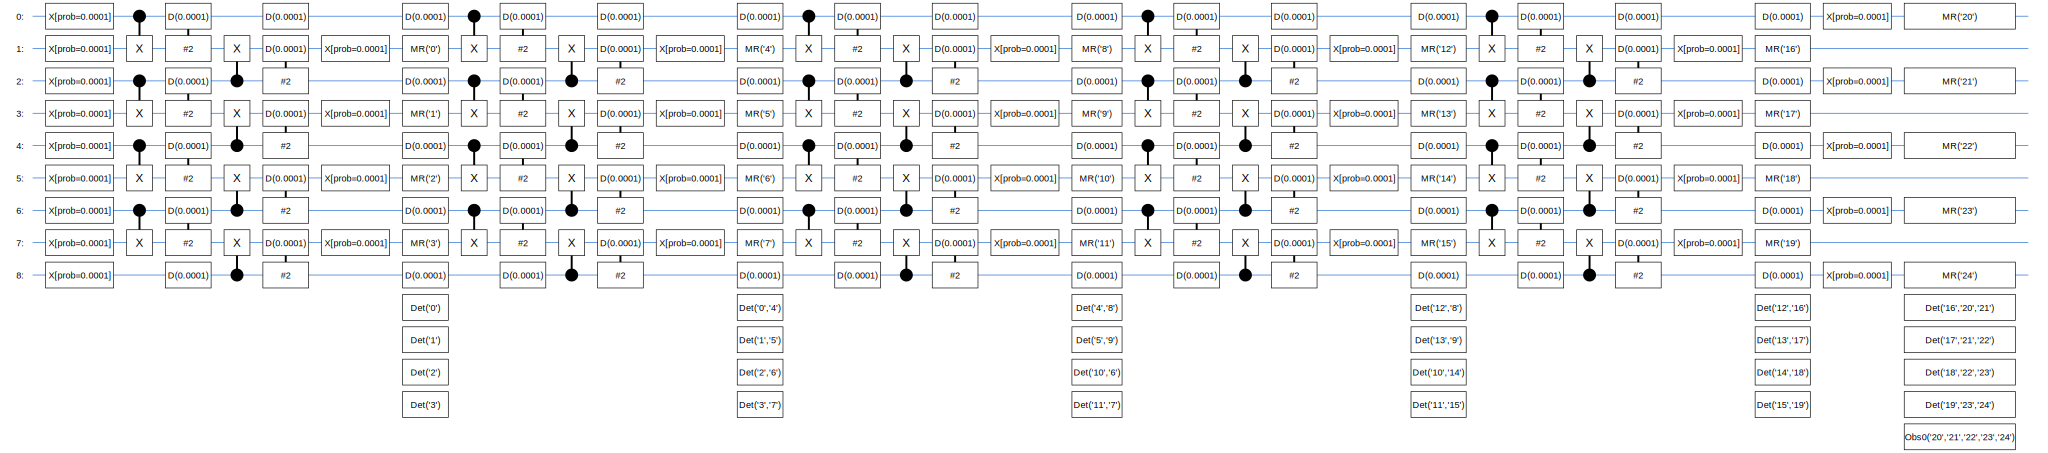

In [4]:
cirq_circuit = stimcirq.stim_circuit_to_cirq_circuit(circuit)
SVGCircuit(cirq_circuit)

In [5]:
distance, R, err = 9, 100, 0.01
circuit = Repetition_code(distance,R,err)
num_shots = 10_000
num_logical_errors = TQEC_tools.count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 8 wrong predictions (logical errors) out of 10000 shots


In [25]:
tasks = [
    sinter.Task(
        circuit=Repetition_code(d,d*3,noise),
        json_metadata={'d': d, 'p': noise},
    )
    for d in [3, 5, 7, 9]
    for noise in np.linspace(1e-4,1e-1,num=15)
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000,
    max_errors=2000,
)

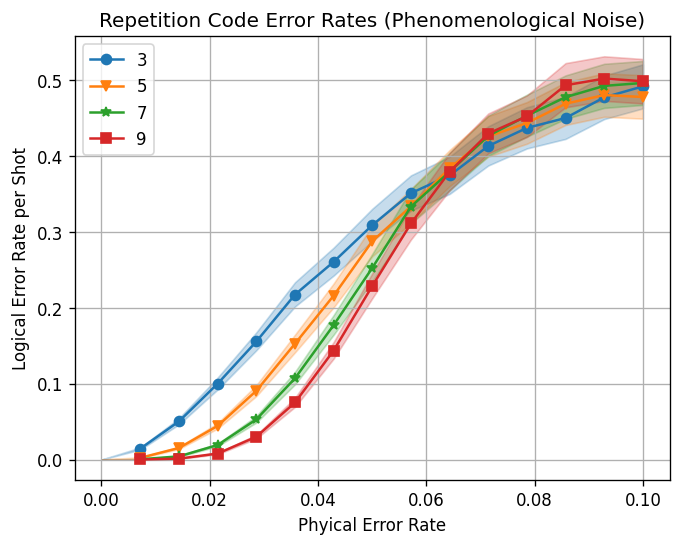

In [26]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)

ax.set_title("Repetition Code Error Rates (Phenomenological Noise)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)